# Lab2 Exploring Image Data

## 1.Buisiness Understanding


Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. 

I got this dataset from [kaggle](https://www.kaggle.com/omkargurav/face-mask-dataset). There are 3710 with-mask images and 3828 without images in two directories. To meet the requirement of this assignment, I would do some manipulations before I process the image datas. The task I choose this dataset is that I need to determine whether a person is wearing face mask from the image captured.

Due to the pandemic, it's essential for everybody to wear face mask in public places. A face mask detection system is meaningful. For example, it could be applied for entry validation when someone try to enter some public places or friendly reminder. In addition, we can pay for the machine to do this job instead of human since I saw number of these people in front of the entrance of shopping malls and hotels or somewhere near the entrance to ensure anyone who wants to enter the place to wear face mask. For business use, the accuracy of this mask detection should at least be greater than 90%. However, since there are little noice factors to this dataset, which is somewhat different from the real circumstance, it would be meaningful if the accuracy is up to 97%. 

## 2.Data Preparation

- Read in your images as numpy arrays. Resize and recolor images as necessary. 
- Linearize the images to create a table of 1-D image features (each row should be one image). 
- Visualize several images.

### 2.1 import the lib needed

In [1]:
#import the lib needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
from sklearn.decomposition import PCA
from numpy import random
import skimage
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.feature import daisy
from skimage.feature import match_descriptors

print("numpy version is:",np.__version__)
print("pandas version is:",pd.__version__)
print("Pillow version is:",Image.__version__)
print("skimage version is:",skimage.__version__)

# which platform right now I located 
# import platform 
# print(platform.system())
# print(platform.release())
# print(platform.version())

numpy version is: 1.19.2
pandas version is: 1.1.3
Pillow version is: 8.1.1
skimage version is: 0.17.2


### 2.2 Importing the requirement image files as dataset
Since I got this images classified yet and with different sizes, I had to resize them to 100*100 and move some of them to another directory as the train dataset.

In [2]:
# %%time
#Because the image files I got is pre-classfied, to meet the requirement of this assignment, I would put 800 each of with-mask image files and without-mask image files into another directory. Since the image files are different sizes, I need to pick the size greater than 100*100 and make it as my dataset after resizing.
path_with_masks = "./data/mask_data/with_mask"
path_without_masks = "./data/mask_data/without_mask"
path_train_uniform_dataset = "./data/mask_data/train_uniform_dataset.nosync"

with_masks_prefix = "with_mask_"
without_mask_prefix = "without_mask_"

files_with_masks = os.listdir(path_with_masks)
files_without_masks = os.listdir(path_without_masks)
print("with_mask original size is:",len(files_with_masks))
print("without_mask original size is:",len(files_without_masks))
pick_img_number = 800
image_uniform_size = [100,100]#the size of image after resizing

if False == os.path.exists(path_train_uniform_dataset):
    os.mkdir(path_train_uniform_dataset)
    count = 0
    for i in range(len(files_with_masks)):
        #convert image file to RGB color
        img_with_mask_tmp = Image.open(os.path.join(path_with_masks,with_masks_prefix+str(i+1)+".jpg"),'r').convert("RGB")
        img_without_mask_tmp = Image.open(os.path.join(path_without_masks,without_mask_prefix+str(i+1)+".jpg"),'r').convert("RGB")
        img_with_mask_tmp = img_with_mask_tmp.resize(image_uniform_size,Image.ANTIALIAS)
        img_without_mask_tmp = img_without_mask_tmp.resize(image_uniform_size,Image.ANTIALIAS)
        img_with_mask_tmp.save(os.path.join(path_train_uniform_dataset,with_masks_prefix+str(i+1)+".jpg"))
        img_without_mask_tmp.save(os.path.join(path_train_uniform_dataset,without_mask_prefix+str(i+1)+".jpg"))
        count += 1
        if (count>=pick_img_number): break

# for img in os.listdir(path_train_uniform_dataset):
print("train dataset is :",len(os.listdir(path_train_uniform_dataset)))

with_mask original size is: 3710
without_mask original size is: 3828
train dataset is : 1600


### 2.3 Displaying several resized images

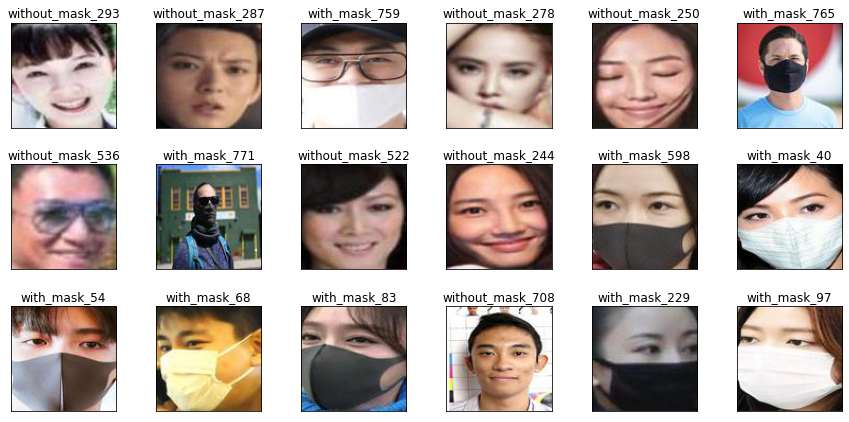

In [3]:
#display several resized images
def plot_raw_gallery(n_row=3, n_col=6):
    plt.figure(figsize=(2*n_col, 2*n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    total = n_row * n_col
    i = 1
    for img_name in os.listdir(path_train_uniform_dataset):
        plt.subplot(n_row, n_col, i)
        img_tmp = plt.imread(os.path.join(path_train_uniform_dataset,img_name))
        plt.imshow(img_tmp)
        plt.title(img_name[:-4], size=12)
        plt.xticks(())
        plt.yticks(())
        i += 1
        if i > total: break

#display some images, copied from "04 Dimension Reduction and Images.ipynb" and made a little adjustment
def plot_gallery(images, titles, h=image_uniform_size[0], w=image_uniform_size[1], n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

#display a few images resized
plot_raw_gallery()

### 2.4 reading image file into numpy array
Linearize the images to create a table of 1-D image features (each row should be one image)

In [4]:
# %%time
train_img_name_list = os.listdir(path_train_uniform_dataset)

np_data = np.array([np.array(Image.open(os.path.join(path_train_uniform_dataset,img_name)).convert("L")).reshape(image_uniform_size[0]*image_uniform_size[1]) for img_name in train_img_name_list])#image data

np_target = np.array([img_name.count("with_mask_") for img_name in train_img_name_list])#target value
np_titles = np.array([img_name[:-4] for img_name in train_img_name_list])#image title

print(type(np_data))
print(type(np_titles))
print(type(np_target))
print(np_data.shape)
print(np_titles.shape)
print(np_target.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1600, 10000)
(1600,)
(1600,)


In [5]:
print(np_data)
print(np_titles)
print(np_target)
print(np.unique(np_target))
print(np.count_nonzero(np_target))#there are 800 images with mask and 800 images without mask

[[ 22  22  21 ... 167 208 225]
 [ 13  13  14 ...  57  57  57]
 [144 141 138 ... 111  90  98]
 ...
 [ 11  11  11 ...  70  87 101]
 [152 153 154 ...  46  48  50]
 [244 244 244 ... 171 170 169]]
['without_mask_293' 'without_mask_287' 'with_mask_759' ...
 'without_mask_275' 'with_mask_797' 'with_mask_783']
[0 0 1 ... 0 1 1]
[0 1]
800


### 2.5 Display several greyscale images from np_data

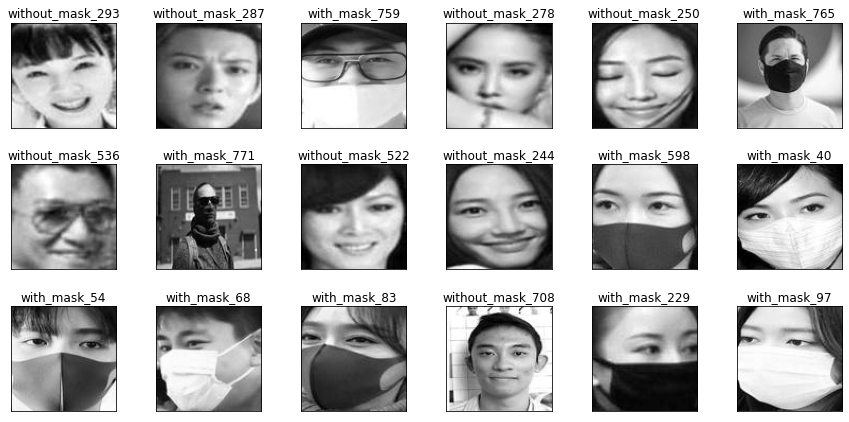

In [6]:
plot_gallery(np_data, np_titles, image_uniform_size[0], image_uniform_size[1]) # defaults to showing a 3 by 6 subset of the faces

## 3.Data Reduction

- Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
- Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
-  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?
- Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).
- Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  

### 3.1 Perform linear dimensionality reduction of the images using PCA

In [7]:
#directly copied from "04 Dimension Reduction and Images.ipynb"
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [8]:
# %%time
def show_plot_explained_variance(n_components,np_data,svd_solver='auto'):
    print ("Extracting the top %d eigenfaces from %d faces" % (n_components, np_data.shape[0]))
    pca = PCA(n_components=n_components,svd_solver = svd_solver)
    %time pca.fit(np_data)
    plot_explained_variance(pca)


# n_components = 200
# print ("Extracting the top %d eigenfaces from %d faces" % (
#     n_components, np_data.shape[0]))

# pca = PCA(n_components=n_components)
# %time pca.fit(np_data.copy())
# eigenfaces = pca.components_.reshape((n_components, image_uniform_size[0], image_uniform_size[1]))

300 is a neat value for PCA components since it could explain roughly **97%** data.

In [9]:
%%time
show_plot_explained_variance(500,np_data)

Extracting the top 500 eigenfaces from 1600 faces
CPU times: user 18.8 s, sys: 1.28 s, total: 20.1 s
Wall time: 3.01 s


CPU times: user 19.5 s, sys: 1.52 s, total: 21 s
Wall time: 3.46 s


### 3.2 Perform linear dimensionality reduction of randomized PCA

Similar to the PCA case, 300 components could explain **97%** dataset.

In [10]:
%%time
show_plot_explained_variance(500,np_data,'randomized')
# plot_explained_variance(rpca)

Extracting the top 500 eigenfaces from 1600 faces
CPU times: user 18.2 s, sys: 797 ms, total: 19 s
Wall time: 2.62 s


CPU times: user 18.4 s, sys: 854 ms, total: 19.2 s
Wall time: 2.66 s


### 3.3 Compare the representation using PCA and Randomized PCA

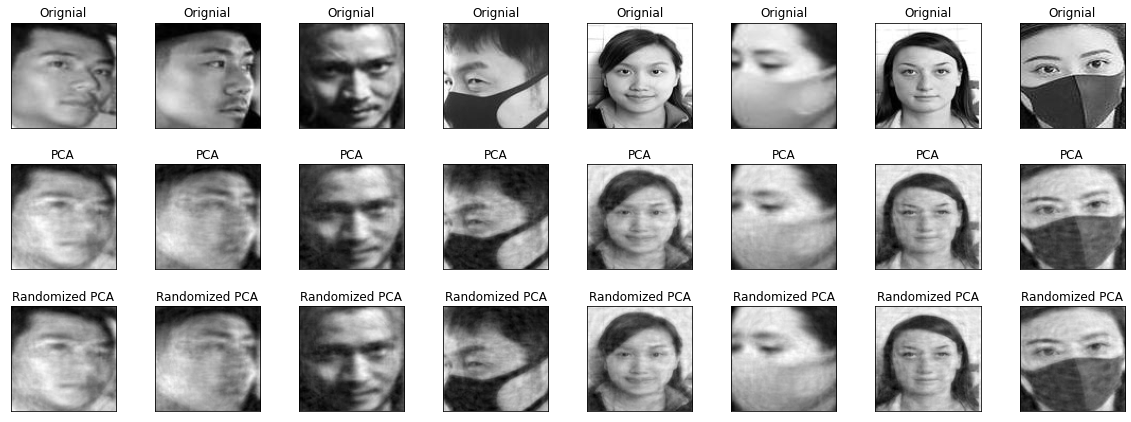

In [11]:
pca = PCA(n_components=300).fit(np_data.copy())
pca_components = pca.transform(np_data)
pca_data = pca.inverse_transform(pca_components)#reconstruct the images by pca

rpca = PCA(n_components=300,svd_solver="randomized").fit(np_data.copy())
rpca_components = rpca.transform(np_data)
rpca_data = rpca.inverse_transform(rpca_components)#reconstruct the image by randomized pca

# print(pca_data[0])
# print(rpca_data[0])
def compare_raw_pca_rpca(np_data,pca_data,rpca_data, h=image_uniform_size[0], w=image_uniform_size[1],n_col=8):
    n_row=3
    n_col=8
    offset = random.randint(pick_img_number-50)
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row*n_col):
        plt.subplot(n_row, n_col, i + 1)
        if i/n_col < 1:
            plt.imshow(np_data[i%n_col+offset].reshape((h, w)), cmap=plt.cm.gray)
            plt.title("Orignial", size=12)
        elif i/n_col < 2:
            plt.imshow(pca_data[i%n_col+offset].reshape((h, w)), cmap=plt.cm.gray)
            plt.title("PCA", size=12)
        else:
            plt.imshow(rpca_data[i%n_col+offset].reshape((h, w)), cmap=plt.cm.gray)
            plt.title("Randomized PCA", size=12)
        plt.xticks(())
        plt.yticks(())

compare_raw_pca_rpca(np_data,pca_data,rpca_data)


In [12]:
def display_accuracy_by_features(components,np_target,title):
    knn = KNeighborsClassifier(n_neighbors=1)
    x_train, x_test, y_train, y_test = train_test_split(
        components,np_target,test_size=0.2, train_size=0.8)
    knn.fit(x_train,y_train)
    # print("knn.predict(x_test):",type(knn.predict(x_test)))
    print(title,accuracy_score(knn.predict(x_test),y_test))

In [24]:
#It seems a terrible idea to use logistic regression here because its low accuracy and slow performance.
from sklearn.linear_model import LogisticRegression

def display_classification_accuracy(np_data,np_target,title):
    logr = LogisticRegression(solver='liblinear')
    x_train, x_test, y_train, y_test = train_test_split(
        np_data,np_target,test_size=0.2, train_size=0.8)
    logr.fit(x_train,y_train)
    print(title,accuracy_score(y_test,logr.predict(x_test))) 

%time display_classification_accuracy(np_data,np_target,"data accuracy:")
%time display_classification_accuracy(rpca_data,np_target,"Randomized PCA accuracy:")

data accuracy: 0.75
CPU times: user 27.6 s, sys: 3.39 s, total: 31 s
Wall time: 6.66 s
Randomized PCA accuracy: 0.7
CPU times: user 24.2 s, sys: 2.98 s, total: 27.1 s
Wall time: 5.41 s


In [14]:
%time display_accuracy_by_features(pca_components,np_target,"PCA accuracy")
%time display_accuracy_by_features(rpca_components,np_target,"Randomized PCA accuracy")

PCA accuracy 0.875
CPU times: user 173 ms, sys: 33.3 ms, total: 206 ms
Wall time: 40.4 ms
Randomized PCA accuracy 0.815625
CPU times: user 128 ms, sys: 19.8 ms, total: 148 ms
Wall time: 19.6 ms


Based on less time consumption, I'd prefer the Randomized PCA because we can't make people wait too long for mask detection. Besides, we still can use human detection as an auxiliary means.

I have run tens of times and come to a roughly conclusion that the Randomized PCA is advanced in less time consumption. For accuracy, sometimes the Randomized PCA is better while sometimes it is worse. If I have to choose one of them for the mask detection task, I may choose Randomized PCA because of its less time consumption and make human detection as an auxiliary means. However, my customer may not pay for this because the accuracy is less than 90%, so both of them may not be suitable.

### 3.4 Perform feature extraction
Using daisy for feature extraction in this part and following the example of "04 Dimension Reduction and Image.ipynb"

In [15]:
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=10, radius=20, 
                 rings=4, histograms=8, orientations=4, 
                 visualize=False)
    return feat.reshape((-1))

%time daisy_features = np.apply_along_axis(apply_daisy, 1, np_data, image_uniform_size)

CPU times: user 12.8 s, sys: 160 ms, total: 13 s
Wall time: 12.2 s


In [16]:
%time display_accuracy_by_features(pca_components,np_target,"PCA accuracy")
%time display_accuracy_by_features(rpca_components,np_target,"Randomized PCA accuracy")
%time display_accuracy_by_features(daisy_features,np_target,"daisy accuracy")

PCA accuracy 0.840625
CPU times: user 165 ms, sys: 23.9 ms, total: 189 ms
Wall time: 31 ms
Randomized PCA accuracy 0.821875
CPU times: user 135 ms, sys: 17.2 ms, total: 152 ms
Wall time: 19.3 ms
daisy accuracy 0.93125
CPU times: user 584 ms, sys: 82.9 ms, total: 667 ms
Wall time: 88.5 ms


Since the accuracy of daisy is greater than 90%, my customer may pay for it, but it has room to optimize due to its time consumption.

In [17]:
# from skimage.filters import gabor_kernel
# from scipy import ndimage as ndi
# from scipy import stats

# # prepare filter bank kernels
# kernels = []
# for theta in range(8):# orientations
#     theta = theta / 8. * np.pi
#     for sigma in (1, 3, 5): # std
#         for frequency in (0.05, 0.15, 0.25, 0.35): # frequency
#             kernel = np.real(gabor_kernel(frequency, theta=theta,
#                                           sigma_x=sigma, sigma_y=sigma))
#             kernels.append(kernel)

            
# # compute the filter bank and take statistics of image
# # this can be drastically sped up using the 2D FFT
# def compute_gabor(row, kernels, shape):
#     feats = np.zeros((len(kernels), 4), dtype=np.double)
#     for k, kernel in enumerate(kernels):
#         filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
#         _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
#         # mean, var, skew, kurt
        
#     return feats.reshape(-1)

# idx_to_reconstruct = int(np.random.rand(1)*len(np_data))

# gabr_feature = compute_gabor(np_data[idx_to_reconstruct], kernels, image_uniform_size)
# %time gabor_stats = np.apply_along_axis(compute_gabor, 1, np_data, kernels, image_uniform_size)

In [18]:
# %time display_accuracy_by_features(gabor_stats,np_target,"gabor accuracy")

I also tried the feature extraction of gabor, the accuracy is lower than PCA and thus not recommended.

## 4.Exceptional Work (1 points total)


One idea (required for 7000 level students): Perform feature extraction upon the images using DAISY. Rather than using matching go the images with the total DAISY vector, you will instead use key point matching. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive.

I compare each image in the test dataset with every image in the train dataset by key points matching and take the maximum matching classes as the similar image to predict the result.

In [19]:
def apply_daisy_v2(row,shape): # no reshape in this function
    feat = daisy(row.reshape(shape), step=10, radius=20, 
                 rings=4, histograms=8, orientations=4, 
                 visualize=False)
    s = feat.shape # PxQxR
    #P = ceil((Height - radius*2) / step) 
    #Q = ceil((Width - radius*2) / step) 
    #R = (rings * histograms + 1) * orientations
    return feat.reshape((s[0]*s[1],s[2]))

x_train, x_test, y_train, y_test = train_test_split(np_data,np_target,test_size=0.2, train_size=0.8)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1280, 10000)
(320, 10000)
(1280,)
(320,)


In [20]:
%%time

y_predict = []

# for i in range(x_test.shape[0]):
#     max_keypoints_matching = 0
#     max_keypoints_matching_class = 0
#     for j in range(x_train.shape[0]):
#         d1 = apply_daisy_v2(x_test[i],image_uniform_size)
#         d2 = apply_daisy_v2(x_train[j],image_uniform_size)
#         if 0==max_keypoints_matching:
#             max_keypoints_matching = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8).shape[0]
#             max_keypoints_matching_class = j
#         else:
#             tmp_max_keypoints_matching = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8).shape[0]
#             if tmp_max_keypoints_matching > max_keypoints_matching:
#                 max_keypoints_matching = tmp_max_keypoints_matching
#                 max_keypoints_matching_class = j
    
#     y_predict.append(y_train[max_keypoints_matching_class])


# print("keypoints matching using daisy accuracy",accuracy_score(np.array(y_predict),y_test))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


The accuracy of key points matching algorithm is close to the K Nearest Neighbor one. There may be room for optimization. However, I don't know how to evaluate the effect of feature extraction and matching algorithm, so I have no idea of the upper limit of these two stages. Besides, the performance time is not acceptable for business use. Maybe the afterward course would introduce more interesting algorithm to improve the accuracy. 